In [ ]:
from music21 import converter, instrument, note, chord, stream
import numpy
from matplotlib import pyplot as plt
import keras
from sklearn.preprocessing import OneHotEncoder
from keras import Sequential, Model
from keras.layers import LSTM, Dropout, Dense, Activation, Input, concatenate
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Dropout
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Embedding
import tensorflow as tf
from tqdm import tqdm
import numpy as np

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/chopin/
  inflating: dataset/chopin/chpn-p12.mid  
  inflating: dataset/chopin/chpn-p15.mid  
  inflating: dataset/chopin/chpn-p16.mid  
  inflating: dataset/chopin/chpn-p17.mid  
  inflating: dataset/chopin/chpn-p18.mid  
  inflating: dataset/chopin/chpn-p19.mid  
  inflating: dataset/chopin/chpn-p20.mid  
  inflating: dataset/chopin/chpn-p21.mid  
  inflating: dataset/chopin/chpn-p22.mid  
  inflating: dataset/chopin/chpn-p23.mid  
  inflating: dataset/chopin/chpn-p24.mid  
  inflating: dataset/chopin/chpn-p7.mid  
  inflating: dataset/chopin/chpn_op10_e01.mid  
  inflating: dataset/chopin/chpn_op10_e05.mid  
  inflating: dataset/chopin/chpn_op10_e12.mid  
  inflating: dataset/chopin/chpn_op23.mid  
  inflating: dataset/chopin/chpn_op25_e1.mid  
  inflating: dataset/chopin/chpn_op25_e2.mid  
  inflating: dataset/chopin/chpn_op25_e3.mid  
  inflating: dataset/chopin/chpn_op25_e4.mid  
  inflating: dataset/chopin/chpn_op2

In [ ]:
def get_notes(midi):
  notes = []
  for element in midi.flatten().notesAndRests:
    if isinstance(element , note.Note):
      notes.append((float(element.offset), float(element.volume.velocity),float(element.seconds), str(element.pitch)))
    elif isinstance(element, chord.Chord):
      notes.append((float(element.offset), float(element.volume.velocity), float(element.seconds), '+'.join(str(n) for n in element.normalOrder)))
    elif isinstance(element, note.Rest):
        # Bizarre car main gauche et droite flatten (réunie)
        # Voir autre implémentation
        #notes.append((float(element.offset), 0,float(element.seconds), "REST"))
        pass
  return notes



In [ ]:
midi = converter.parse("/content/dataset/chopin/chp_op18.mid")

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


In [ ]:
for element in midi.parts:
    if "left" in element.partName:
      notes = get_notes(element)

In [ ]:
input_note, output_note = [], []
input_offset, output_offset = [], []
input_volume, output_volume = [], []
input_duration, output_duration = [], []



sequence_length = 50
note_all_songs = []
for folder in tqdm(os.walk("dataset")):
    if len(folder) != 3:
      continue
    else:
      for file in folder[2][:5]:
        file_path = str(folder[0])+"/"+file

        # convertit la piste midi
        midi = converter.parse(file_path)


        # récupère les notes, volume, dureées...
        notes = get_notes(midi)

        # ajoute à une liste globale
        note_all_songs.append(notes)

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2010 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2007 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
2it [01:07, 33.62s/it]/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine

In [ ]:
# fais un dataframe à partir de toutes les notes (sans distinctions)
df = pd.DataFrame([], columns=['debut_note','volume','durée(s)', 'pitch/chord'])
df = df.reset_index(drop=True)
for elem in note_all_songs:
    df2 = pd.DataFrame(elem, columns=['debut_note','volume','durée(s)', 'pitch/chord'])
    df2 = df2.reset_index(drop=True)
    df =pd.concat([df,df2])
    df = df.reset_index(drop=True)

In [ ]:

def check_pitch(x):
  if ('+' in x) or x.isdigit():
        notes_in_chord = x.split('+')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord =chord.Chord(notes).pitches[0].midi
        return new_chord
    # pattern is a note
  elif ("REST" in x):
    return 0
  else:
        new_note = note.Note(x).pitch.midi
        return new_note
df['MIDI Pitch'] = df['pitch/chord'].apply(lambda x: check_pitch(x))


In [ ]:
notes

In [ ]:
import statsmodels.api as sm

df = pd.DataFrame(notes, columns=['debut_note','volume','durée(s)', 'pitch/chord'])
df['MIDI Pitch'] = df['pitch/chord'].apply(lambda x: check_pitch(x))

note_model = sm.tsa.ARIMA(df['MIDI Pitch'])

note_results = note_model.fit()

NameError: ignored

In [ ]:
for p in range(0,10):
    for q in range(0,10):
        for d in range(0,10):
            mod = sm.tsa.ARIMA(df['MIDI Pitch'], order=(p,d,q))
            res = mod.fit()
            print("p={}, d={}, q={} --> AICc = {}".format(p,d,q, res.aicc))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


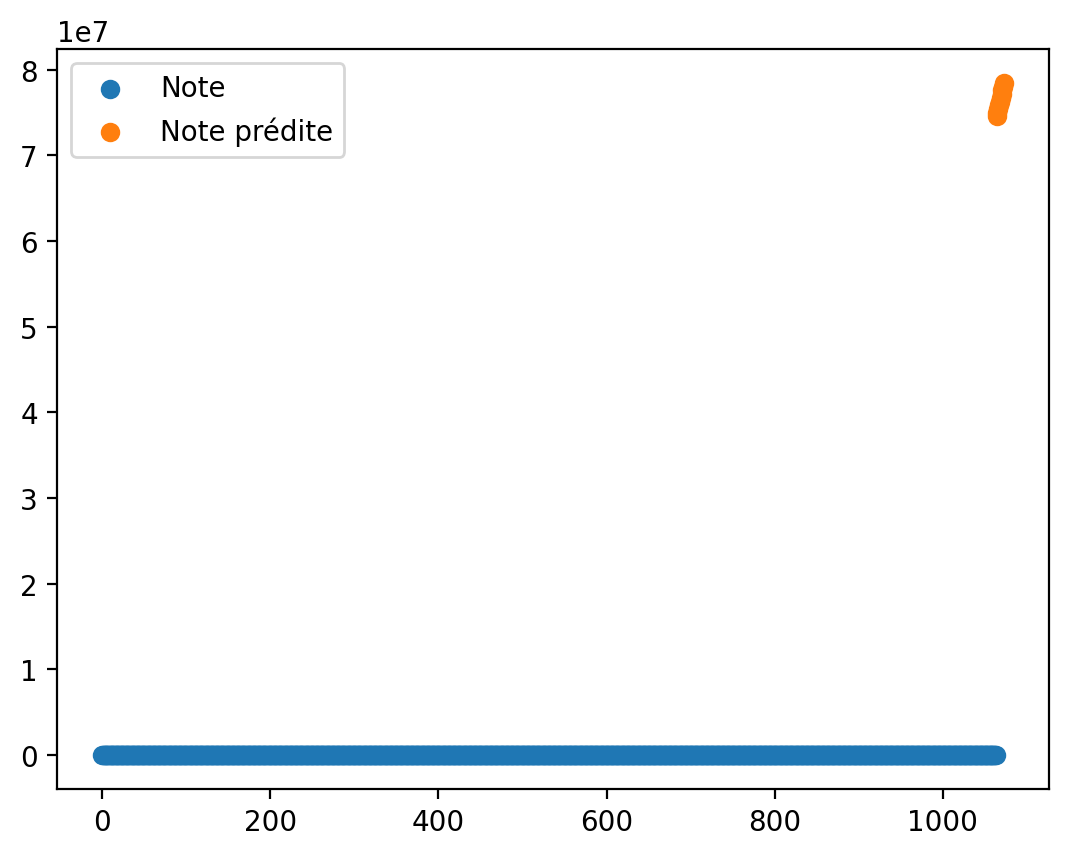

In [ ]:
n_periods = 10
note_results = sm.tsa.ARIMA(df['MIDI Pitch'], order=(0,6,5)).fit()
note_forecast = note_results.forecast(steps=n_periods)

plt.scatter(x=range(0, len(df)), y=df['MIDI Pitch'],  label='Note')
plt.scatter(x=range(len(df),len(df)+10), y=note_forecast,  label='Note prédite')
plt.legend()
plt.show()

In [ ]:
#train les encoders pour les notes, volumes et durées en catégorielles (one hot)
# sur intégralité des données (obligé)
oh_notes =  OneHotEncoder().fit(df[['pitch/chord']])


# seuil/catégories modifiable
df["volume_class"] = pd.cut(df["volume"], bins=[0,10,30,50,70,90,127], labels=["very low", "low", "low medium", "medium", "high", "very high"])
oh_volume =  OneHotEncoder().fit(df[['volume_class']])

df["duration_class"] = pd.cut(df["durée(s)"], bins=[0, 0.1, 0.25, 0.5, 0.75, 1, 1.5,df["durée(s)"].max()], labels=["very short", "short", "medium", "medium-long", "long", "very long", "super mega long"])
oh_duration =  OneHotEncoder().fit(df[['duration_class']])


In [ ]:
def prepare_sequence(data, sequence_length, network_input, network_output):
  # create input sequences and the corresponding outputs
  for i in range(0, len(data) - sequence_length, 1):
      sequence_in = data[i:i + sequence_length]
      sequence_out = data[i + sequence_length]
      network_input.append(sequence_in)
      network_output.append(sequence_out)
  return (network_input, network_output)

def reshape_array_input(array_tensor, sequence_length):
  n_patterns = len(array_tensor)
  array_reshaped = numpy.reshape(array_tensor, (n_patterns, sequence_length, -1))
  return array_reshaped

def reshape_array_output(array_tensor, sequence_length):
  n_patterns = len(array_tensor)
  array_reshaped = numpy.reshape(array_tensor, (len(array_tensor), -1))
  return array_reshaped


In [ ]:
sequence_length = 100

In [ ]:
input_note, output_note = [], []
input_volume, output_volume = [], []
input_duration, output_duration = [], []

# pour chaque music, on la transforme en dataframe, transforme les notes, durées et volumes
for music in note_all_songs:
  df_music = pd.DataFrame(music, columns=['debut_note','volume','durée(s)', 'pitch/chord'])

  # encode le volume et la durée
  df_music["duration_class"] = pd.cut(df_music["durée(s)"], bins=[0, 0.1, 0.25, 0.5, 0.75, 1, 1.5,10], labels=["very short", "short", "medium", "medium-long", "long", "very long", "super mega long"])
  df_music["volume_class"] = pd.cut(df_music["volume"], bins=[0,10,30,50,70,90,127], labels=["very low", "low", "low medium", "medium", "high", "very high"])

  # transform en one hot à partir des modèles entrainés
  notes_encoded = oh_notes.transform(df_music[['pitch/chord']]).toarray()
  volume_encoded = oh_volume.transform(df_music[['volume_class']]).toarray()
  duration_encoded = oh_duration.transform(df_music[['duration_class']]).toarray()

  # prépare les input (longeur = sequence_length) pour chaque morceau
  # garde certaine cohérence au morceau même
  input_note, output_note = prepare_sequence(notes_encoded, sequence_length, input_note, output_note)
  input_volume, output_volume = prepare_sequence(volume_encoded, sequence_length, input_volume, output_volume)
  input_duration, output_duration = prepare_sequence(duration_encoded, sequence_length, input_duration, output_duration)

In [ ]:
# on reshape tout
input_note_reshaped= reshape_array_input(input_note, sequence_length)
output_note_reshaped = reshape_array_output(output_note, sequence_length)

input_volume_reshaped= reshape_array_input(input_volume, sequence_length)
output_volume_reshaped = reshape_array_output(output_volume, sequence_length)

input_duration_reshaped= reshape_array_input(input_duration, sequence_length)
output_duration_reshaped = reshape_array_output(output_duration, sequence_length)


In [ ]:
#création du modèle (à alléger si overfitting)
inputNotes_layer = Input(shape=(input_note_reshaped.shape[1], input_note_reshaped.shape[2]))
inputNotes = LSTM(
        128,
        input_shape=(input_note_reshaped.shape[1], input_note_reshaped.shape[2]),
        return_sequences=True
    )(inputNotes_layer)

inputVolume_layer = Input(shape=(input_volume_reshaped.shape[1], input_volume_reshaped.shape[2]))
inputVolume = LSTM(
        128,
        input_shape=(input_volume_reshaped.shape[1], input_volume_reshaped.shape[2]),
        return_sequences=True
    )(inputVolume_layer)

inputDuration_layer = Input(shape=(input_duration_reshaped.shape[1], input_duration_reshaped.shape[2]))
inputDuration = LSTM(
        128,
        input_shape=(input_duration_reshaped.shape[1], input_duration_reshaped.shape[2]),
        return_sequences=True
    )(inputDuration_layer)

inputs = concatenate([inputNotes, inputVolume, inputDuration])
x = LSTM(256, return_sequences=True)(inputs)
x = Dropout(0.3)(x)
x = LSTM(256)(inputs)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)

outputNotes = Dense(256, activation='relu')(x)
outputNotes = Dense(output_note_reshaped.shape[1], activation='softmax', name="Note")(outputNotes)

outputVolume = Dense(256, activation='relu')(x)
outputVolume = Dense(output_volume_reshaped.shape[1], activation='softmax', name="Volume")(outputVolume)

outputDuration = Dense(256, activation='relu')(x)
outputDuration = Dense(output_duration_reshaped.shape[1], activation='softmax', name="Duration")(outputDuration)




model = Model(inputs=[inputNotes_layer, inputVolume_layer, inputDuration_layer], outputs=[outputNotes, outputVolume, outputDuration])

#Adam seems to be faster than RMSProp and learns better too
model.compile(loss=['categorical_crossentropy', "mean_squared_error", "categorical_crossentropy", "categorical_crossentropy"], optimizer='adam')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 295)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100, 6)]             0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 100, 7)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 100, 128)             217088    ['input_1[0][0]']             
                                                                                              

In [ ]:
import os

cp_callback = keras.callbacks.ModelCheckpoint(
    'model_weights_epoch.h5',  # Nom du fichier de sauvegarde avec un espace réservé pour le numéro de l'époque
    save_best_only=True,  # Sauvegarder à chaque époque, pas seulement les meilleurs modèles
    save_weights_only=True,  # Sauvegarder uniquement les poids, pas l'ensemble du modèle
    verbose=1  # Afficher un message lors de la sauvegarde
    )

In [ ]:
model.fit([input_note_reshaped, input_volume_reshaped, input_duration_reshaped], [output_note_reshaped, output_volume_reshaped, output_duration_reshaped], epochs=400, callbacks=[cp_callback], validation_split=0.2, batch_size=128)

In [ ]:
#prend une séquence de notes, volume, durées
pattern_note = input_note[-1]
pattern_volume = input_volume[-1]
pattern_duration = input_duration[-1]

In [ ]:
# prediction time
prediction_output = []

for i in tqdm(range(200)):

    #on reshape les input à prédire
    note_prediction_input = numpy.reshape(pattern_note, (1, len(pattern_note), -1))
    volume_prediction_input = numpy.reshape(pattern_volume, (1, len(pattern_volume), -1))
    duration_prediction_input = numpy.reshape(pattern_duration, (1, len(pattern_duration), -1))

    #prédit ici
    prediction = model.predict([note_prediction_input, volume_prediction_input, duration_prediction_input], verbose=0)

    # prédis la note en récupérant l'index max du softmax et en faisant la transofr inverse
    # à partir du one hot train sur les notes
    notes_pred = np.zeros(len(pattern_note[0]))
    notes_pred[np.argmax(prediction[0])] = 1
    result_note = oh_notes.inverse_transform(notes_pred.reshape(1, -1))
    pattern_note = numpy.concatenate([pattern_note, prediction[0]])
    pattern_note = pattern_note[1:]

    # la même avec le volume
    volume_pred = np.zeros(len(pattern_volume[1]))
    volume_pred[np.argmax(prediction[1])] = 1
    result_volume = oh_volume.inverse_transform(volume_pred.reshape(1, -1))
    pattern_volume = numpy.concatenate([pattern_volume, prediction[1]])
    pattern_volume = pattern_volume[1:]

    # la même avec la durée
    duration_pred = np.zeros(len(pattern_duration[0]))
    duration_pred[np.argmax(prediction[2])] = 1
    result_duration = oh_duration.inverse_transform(duration_pred.reshape(1, -1))
    pattern_duration = numpy.concatenate([pattern_duration, prediction[2]])
    pattern_duration = pattern_duration[1:]

    # comme on prédit un mot associé au volume, on associe au mot une valeur/intensité
    #(manque des catégories)
    volume_encoded = result_volume[0][0]
    volume_decoded = 0
    if volume_encoded == "low":
      volume_decoded = 30
    if volume_encoded == "medium":
      volume_decoded = 60
    if volume_encoded == "high":
      volume_decoded = 90

    # la même avec la durée
    #(manque des catégories)
    duration_encoded = result_duration[0][0]
    duration_encoded = 0
    if volume_encoded == "short":
      duration_encoded = 0.25
    if volume_encoded == "medium":
      duration_encoded = 0.5
    if volume_encoded == "high":
      duration_encoded = 0.75

    #on ajoute la note, le volyme et la durée
    prediction_output.append([result_note[0][0], volume_decoded, duration_encoded])


100%|██████████| 200/200 [00:15<00:00, 12.57it/s]


In [ ]:
from music21.duration import Duration


In [ ]:
offset = 0
output_notes = []
# on passes des prédicitons à un format écoutable à l'oreille

# pour chaque note prédite
for note_p in prediction_output:
    pattern = note_p[0]
    # si note = chord
    if ('+' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('+')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        # met le volume associé
        new_chord.volume.velocity = note_p[1]
        # met la durée associée
        new_chord.duration = Duration(note_p[2])
        output_notes.append(new_chord)
    # si note est un rest
    elif('REST'in pattern):
      note_rest = note.Rest()
      note_rest.offset = offset
      # durée associée (pas de volume car silencieux)
      note_rest.duration = Duration(note_p[2])
      output_notes.append(note_rest)
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.volume.velocity = note_p[1]
        new_note.duration = Duration(note_p[2])
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [ ]:
#into midi
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_outputminecraft.mid')

'test_outputminecraft.mid'